In [152]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import pathlib
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
# !pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys
from tensorflow.keras.optimizers import Adam
# !pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
import segmentation_models as sm
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import PIL.Image
import math

# Functions

In [153]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [154]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [155]:
'''
  Metric functions for evaluation
'''
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return (intersection + smooth) / (union + smooth)

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores


def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process New Dataset

In [156]:
base_dir = r"./Nepal landslide dataset/"

In [157]:
# Ingest images

training_images_list = os.listdir(r"{}Training/image/".format(base_dir))
training_masks_list = []
training_images = []

for n in training_images_list:
    im = PIL.Image.open(r"{}Training/image/{}".format(base_dir, n))
    training_images.append(im)
    # Nepal uses .tiff → label uses .png
    training_masks_list.append(n[:-5] + '.png')

# Training masks
training_masks = []
for n in training_masks_list:
    im = PIL.Image.open(r"{}Training/label/{}".format(base_dir, n))
    training_masks.append(im)

# -------------------------
# Test images
# -------------------------
test_images_list = os.listdir(r"{}Test/image/".format(base_dir))
test_images = []

for n in test_images_list:
    im = PIL.Image.open(r"{}Test/image/{}".format(base_dir, n))
    test_images.append(im)

# -------------------------
# Validation images
# -------------------------
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []

for n in validation_images_list:
    im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir, n))
    validation_images.append(im)
    validation_masks_list.append(n[:-5] + '.png')

# Validation masks
validation_masks = []
for n in validation_masks_list:
    im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir, n))
    validation_masks.append(im)


In [158]:
# Pre-process (same as original, only ensure resize)
# -------------------------

# images (3-channel)
for i in range(len(training_images)):
    arr = np.array(training_images[i]) / 255
    arr = cv2.resize(arr, (512, 512))     
    arr = arr.reshape(1, 512, 512, 3)
    training_images[i] = arr.astype('float32')

# masks (1-channel)
for i in range(len(training_masks)):
    arr = np.array(training_masks[i])
    arr = cv2.resize(arr, (512, 512))    
    arr = arr.reshape(1, 512, 512, 1)
    training_masks[i] = arr.astype('int')

# validation images
for i in range(len(validation_images)):
    arr = np.array(validation_images[i]) / 255
    arr = cv2.resize(arr, (512, 512))
    arr = arr.reshape(1, 512, 512, 3)
    validation_images[i] = arr.astype('float32')

# validation masks
for i in range(len(validation_masks)):
    arr = np.array(validation_masks[i])
    arr = cv2.resize(arr, (512, 512))
    arr = arr.reshape(1, 512, 512, 1)
    validation_masks[i] = arr.astype('int')

# test images
for i in range(len(test_images)):
    arr = np.array(test_images[i]) / 255
    arr = cv2.resize(arr, (512, 512))
    arr = arr.reshape(1, 512, 512, 3)
    test_images[i] = arr.astype('float32')

In [159]:
validation_Nepal_landslide_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [160]:
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.3] = 1 # FOREST
    mask[mask <= 0.3] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [161]:
t_images = np.stack(training_images)
t_masks = np.stack(training_masks)
t_images = np.squeeze(t_images, axis=1)
t_masks  = np.squeeze(t_masks, axis=1)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
)

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)


In [162]:
BETA = 0.95
SMOOTH_TERM = 1e-7

def dice_coef(y_true, y_pred, smooth=SMOOTH_TERM):
    y_true_float = K.cast(y_true, 'float32') 
    
    y_true_f = K.flatten(y_true_float)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


  
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=2.0):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')


    TP = K.sum(y_true * y_pred)
    FP = K.sum((1 - y_true) * y_pred)
    FN = K.sum(y_true * (1 - y_pred))

    tversky = (TP + 1e-7) / (TP + alpha*FN + beta*FP + 1e-7)
    focal_tversky = K.pow((1 - tversky), gamma)

    return focal_tversky



In [163]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_iou_metric', 
    mode='max',               
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)


# Models

## U-Net

In [164]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])
    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [165]:
# Print model layers and number of parameters
UNet().summary()

Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_895 (Conv2D)            (1, 512, 512, 64)    1792        ['input_50[0][0]']               
                                                                                                  
 activation_1059 (Activation)   (1, 512, 512, 64)    0           ['conv2d_895[0][0]']             
                                                                                                  
 conv2d_896 (Conv2D)            (1, 512, 512, 64)    36928       ['activation_1059[0][0]']        
                                                                                           

## Attention U-Net

In [166]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7]) 
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])
    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [167]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_914 (Conv2D)            (1, 512, 512, 16)    448         ['input_51[0][0]']               
                                                                                                  
 activation_1078 (Activation)   (1, 512, 512, 16)    0           ['conv2d_914[0][0]']             
                                                                                                  
 conv2d_915 (Conv2D)            (1, 512, 512, 16)    2320        ['activation_1078[0][0]']        
                                                                                           

## ResNet50-SegNet

In [168]:
# Forked code from: https://github.com/ykamikawa/tf-keras-SegNet

from keras.layers import Layer

'''
  Unpooling using max pooling indices
'''

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        padding = 'same'
        pool_size = (2,2)
        strides = (2,2)
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

# Custom version of MaxUnpooling2D
# Takes raw layer values and outputs values
# Takes tf.nn.max_pool_with_argmax output as input
def unpool_with_indices(pool, indices, out_size=2):
  print(pool)
  print(indices)
  # Create empty array of appropriate size
  shape = np.array(np.shape(pool))
  shape = np.array((shape[0], out_size * shape[1], out_size * shape[2], shape[3]))
  out = np.zeros(shape)

  # Make upsample
  inds = np.array(indices).flatten()
  outs = np.array(pool).flatten()
  for i in range(len(inds)):
    blk = inds[i] // (shape[2] * shape[3]) # Find which block to place numbers in
    ln  = inds[i] - (blk * shape[3] * shape[2]) # Find which line
    ln2 = ln // (shape[3]) # Find line
    pos = ln % (shape[3]) # Find position
    #print(blk, ln2, pos)
    out[0][blk][ln2][pos] = outs[i]


  #print(out.shape)
  return (out)

# Own custom code
'''
  ResNet Contraction Phase Block
'''

def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

'''
  SegNet Expansion Phase Block
'''
def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = MaxUnpooling2D((2,2))([pool4, mask4]), filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = MaxUnpooling2D((2,2))([pool3, mask3]), filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = MaxUnpooling2D((2,2))([pool2, mask2]), filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = MaxUnpooling2D((2,2))([pool1, mask1]), filter = filters, kernel = kernel_sz)
  
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
  model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])

  return model

In [169]:
# Print model layers and number of parameters
ResNet50SegNet().summary()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_180 (ZeroPaddin  (None, 514, 514, 3)  0          ['input_52[0][0]']               
 g2D)                                                                                             
                                                                                                  
 conv2d_945 (Conv2D)            (None, 512, 512, 64  1792        ['zero_padding2d_180[0][0]']     
                                )                                                          

## FCN32-VGG16

In [170]:
# Code forked and modified from: https://github.com/divamgupta/image-segmentation-keras

'''
  FCN32-VGG16 model
'''

def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    # Input
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    ## Encoder
    # Block 1
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    # Decoder
    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)
    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="output"))(o)

    # Output
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])
    model.model_name = "fcn_32"
    return model

In [171]:
# Print model layers and number of parameters
fcn_32().summary()

Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 activation_1136 (Activation  (None, 512, 512, 64)     0         
 )                                                               
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 activation_1137 (Activation  (None, 512, 512, 64)     0         
 )                                                               
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0  

## ResUNet

In [172]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]
            
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])
    
    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and 
    final convolution. The input is then put through 
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    #x1 = tf.keras.layers.BatchNormalization()(x)
    #x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Activation('relu')(x)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
                                                            
    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function 
    in detail. Original Unet uses a transpose convolution that downsamples 
    the number of feature maps. In order to restrict the number of 
    parameters here we use a bilinear resampling layer. This results in 
    the concatentation layer concatenting feature maps with n and n/2 
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized
        
def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size, 
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes, 
                                    kernel_size, 
                                    strides=1, 
                                    padding='same', 
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])
    return model

In [173]:
res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 layer1_1 (Conv2D)              (None, 512, 512, 64  1792        ['input_54[0][0]']               
                                )                                                                 
                                                                                                  
 activation_1152 (Activation)   (None, 512, 512, 64  0           ['layer1_1[0][0]']               
                                )                                                          

# Train on New feature data

In [174]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, mode='max')
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch = 230, epochs=40, validation_data = validation_Nepal_landslide_dataset, callbacks=[save_model])

Epoch 1/40
230/230 [==============================] - ETA: 0s - loss: 0.9026 - accuracy: 0.3114 - iou_metric: 0.0282
Epoch 1: val_iou_metric improved from -inf to 0.01038, saving model to unet-3d.hdf5
230/230 [==============================] - 21s 83ms/step - loss: 0.9026 - accuracy: 0.3114 - iou_metric: 0.0282 - val_loss: 0.9353 - val_accuracy: 0.0104 - val_iou_metric: 0.0104
Epoch 2/40
230/230 [==============================] - ETA: 0s - loss: 0.9507 - accuracy: 0.0079 - iou_metric: 0.0079
Epoch 2: val_iou_metric improved from 0.01038 to 0.01038, saving model to unet-3d.hdf5
230/230 [==============================] - 19s 83ms/step - loss: 0.9507 - accuracy: 0.0079 - iou_metric: 0.0079 - val_loss: 0.9353 - val_accuracy: 0.0104 - val_iou_metric: 0.0104
Epoch 3/40
230/230 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.2640 - iou_metric: 0.0345
Epoch 3: val_iou_metric improved from 0.01038 to 0.11439, saving model to unet-3d.hdf5
230/230 [========================

In [175]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

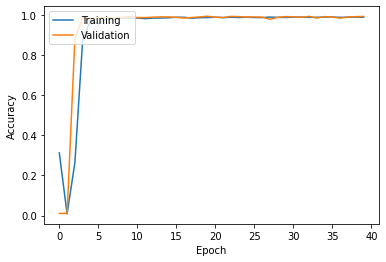

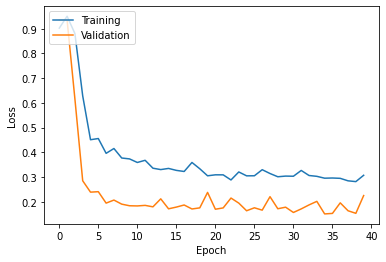

In [176]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [180]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.00001, filter_base=16)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, mode='max' )
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_attention_unet.fit(train, steps_per_epoch = 230, epochs=60, validation_data = validation_Nepal_landslide_dataset, callbacks=[save_model])

Epoch 1/60
230/230 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.9898 - iou_metric: 0.0021
Epoch 1: val_iou_metric improved from -inf to 0.00001, saving model to unet-3d.hdf5
230/230 [==============================] - 19s 76ms/step - loss: 0.9442 - accuracy: 0.9898 - iou_metric: 0.0021 - val_loss: 0.9067 - val_accuracy: 0.9896 - val_iou_metric: 9.5483e-06
Epoch 2/60
230/230 [==============================] - ETA: 0s - loss: 0.8623 - accuracy: 0.9920 - iou_metric: 0.0034
Epoch 2: val_iou_metric improved from 0.00001 to 0.01177, saving model to unet-3d.hdf5
230/230 [==============================] - 17s 75ms/step - loss: 0.8623 - accuracy: 0.9920 - iou_metric: 0.0034 - val_loss: 0.6655 - val_accuracy: 0.9897 - val_iou_metric: 0.0118
Epoch 3/60
230/230 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.9897 - iou_metric: 0.0476
Epoch 3: val_iou_metric improved from 0.01177 to 0.15015, saving model to unet-3d.hdf5
230/230 [====================

In [ ]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

## ResNet50-SegNet

In [ ]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, steps_per_epoch = 100, epochs=50, validation_data = validation_Nepal_landslide_dataset, callbacks=[save_model_resnet])

In [ ]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

## FCN32-VGG16

In [ ]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, mode='max')
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, steps_per_epoch = 100, epochs=50, validation_data = validation_Nepal_landslide_dataset, callbacks=[save_model_fcn32])

In [ ]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

## ResUNet

In [ ]:
R = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
save_model_resunet = ModelCheckpoint('resunet-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, steps_per_epoch = 100, epochs=50, validation_data = validation_Nepal_landslide_dataset, callbacks=[save_model_resunet])

In [ ]:
# Save model history
np.save('resunet-3d-history.npy',R.history.history)

# Import Models and Compute Metrics

## RGB

In [183]:
# Load 3-dim models and history stats
attention_unet = load_model(
    'unet-attention-3d.hdf5',
    custom_objects={
        'iou_metric': iou_metric,
        'focal_tversky_loss': focal_tversky_loss
    }
)

unet = load_model(
    'unet-3d.hdf5',
    custom_objects={'iou_metric': iou_metric,
                    'focal_tversky_loss': focal_tversky_loss
                   }
)

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

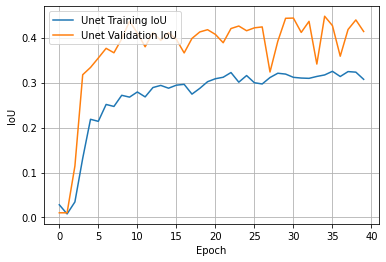

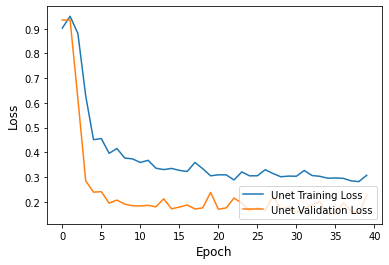

In [184]:
# Plot accuracy and loss for U-Net

## Accuracy

plt.plot(unet_history['iou_metric'])
plt.plot(unet_history['val_iou_metric'])

plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Unet Training IoU', 'Unet Validation IoU'], loc='upper left')
plt.grid(True)
plt.show()


## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Unet Training Loss', 'Unet Validation Loss'], loc='lower right')

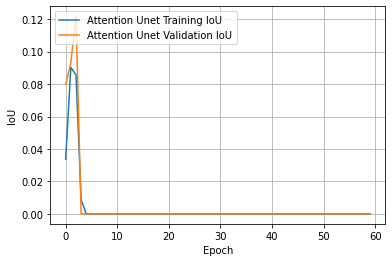

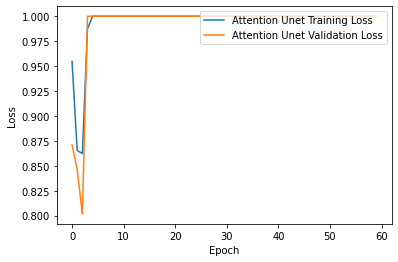

In [185]:
# Plot accuracy and loss for Attention U-Net

## Accuracy

plt.plot(attention_unet_history['iou_metric'])
plt.plot(attention_unet_history['val_iou_metric'])

plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Attention Unet Training IoU', 'Attention Unet Validation IoU'], loc='upper left')
plt.grid(True)
plt.show()


## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Attention Unet Training Loss', 'Attention Unet Validation Loss'], loc='upper right')

In [186]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 34ms/step


In [187]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 30ms/step


In [188]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [189]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9906168256487166 0.008319526048845538
Attention U-Net accuracy:  0.9903775896344866 0.0072942557607365574


In [190]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.9925608462245377 0.0065000623150168
Attention U-Net precision:  0.9887523092162039 0.00888986915949721


In [191]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9906168256487166 0.008319526048845538
Attention U-Net recall:  0.9903775896344866 0.0072942557607365574


In [192]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

U-Net F1-score:  0.9915878831183161
Attention U-Net F1-score:  0.9895642820774264
